In [6]:
from autoencodeSVJ import utils, models, trainer
import glob
import os
import numpy as np
import keras
import keras.backend as K
import matplotlib.pyplot as plt

version_id = 'v4'
SEED = 42

### 1: load and normalize input data
we can use the data_loader for this. 
add an h5 sample, grab the table which represents it, and then split the table into training and testing datasets:

In [12]:
# get h5 datasets
data_path = "data/tightSVJ/10h5/*_data.h5"
signal_path = "data/signal/fullh5/*_data.h5"

data, data_tags, data_jets = utils.load_all_data(data_path, "background")
signal, signal_tags, signal_jets = utils.load_all_data(signal_path, "signal")

split = 0.25

train, test = data.train_test_split(split, SEED)
utils.compare_tags([train, test, data, signal])

data_raw = data.cdrop("*Flavor")
signal_raw = signal.cdrop("*Flavor")
train_raw = train.cdrop("*Flavor")
test_raw = test.cdrop("*Flavor")

norm_args = {"norm_type": "StandardScaler"}
train_norm, test_norm = train_raw.norm(**norm_args), train_raw.norm(test_raw, **norm_args)
data_norm, signal_norm = train_raw.norm(data_raw, **norm_args), train_raw.norm(signal_raw, **norm_args)

background tags:

down jet: 18999, 18.4%
up jet: 38841, 37.6%
strange jet: 25377, 24.5%
charm jet: 9577, 9.3%
bottom jet: 3341, 3.2%
gluon jet: 7281, 7.0%

signal tags:

down jet: 1220, 2.5%
up jet: 1866, 3.8%
strange jet: 1550, 3.1%
charm jet: 3344, 6.8%
bottom jet: 38995, 78.8%
gluon jet: 2541, 5.1%

bottom:
	3.3% (2539) train
	3.1% (802) test
	3.2% (3341) background
	78.8% (38995) signal
up:
	37.4% (28973) train
	38.2% (9868) test
	37.6% (38841) background
	3.8% (1866) signal
down:
	18.4% (14285) train
	18.2% (4714) test
	18.4% (18999) background
	2.5% (1220) signal
strange:
	24.6% (19069) train
	24.4% (6308) test
	24.5% (25377) background
	3.1% (1550) signal
charm:
	9.3% (7238) train
	9.0% (2339) test
	9.3% (9577) background
	6.8% (3344) signal
gluon:
	7.0% (5458) train
	7.1% (1823) test
	7.0% (7281) background
	5.1% (2541) signal


### 2. build model 
To make our model, we'll use the simple "shallow" architecture defined in models.py. This gives us a decidedly shallow autoencoder with a bottleneck of our liking.

In [91]:
bn = 3
name = "bn_{0}_{1}".format(bn, version_id)
repo_head = utils.get_repo_info()['head']
model_path = repo_head + "/autoencode/data/training_runs/7jf/custom/"

ae_skeleton = models.base_autoencoder()
ae_skeleton.add(7)
ae_skeleton.add(100)
ae_skeleton.add(100)
ae_skeleton.add(bn, 'relu')
ae_skeleton.add(100)
ae_skeleton.add(100)
ae_skeleton.add(7, "linear")

autoencoder = ae_skeleton.build()
encoder, decoder = autoencoder.layers[1:]
instance = trainer.trainer(os.path.join(model_path, name))
autoencoder.summary()

h5_elt 'metric_names' :: loading dataset 'data/metric_names' from file 'bn_3_v4.h5'
h5_elt 'training' :: loading dataset 'params/training' from file 'bn_3_v4.h5'
h5_elt 'config' :: loading dataset 'params/config' from file 'bn_3_v4.h5'
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_1 (InputLayer)         (None, 7)                 0         
_________________________________________________________________
encoder (Model)              (None, 3)                 11203     
_________________________________________________________________
decoder (Model)              (None, 7)                 11207     
Total params: 22,410
Trainable params: 22,410
Non-trainable params: 0
_________________________________________________________________


### 3. train model 
this can be most easily done using the `training_skeleton`, defined in `skeletons.py`. This helps with dynamic training and allows for stopping midway without losing history information, retraining models, etc.

In [122]:
from keras import backend as K

def r_square(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return ( 1 - SS_res/(SS_tot + K.epsilon()))

def r_square_np(true, pred):
    SS_res = np.sum(np.square(true - pred), axis=1)
    SS_tot = np.sum(np.square(true - np.mean(true, axis=0)), axis=1)
    return 1. - SS_res/SS_tot

def r_square_loss(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return SS_res/(SS_tot + K.epsilon())

# train, test = data.train_test_split(0.25)
# ntype="RobustScaler"
# train_norm, test_norm = data.norm(train, norm_type=ntype), data.norm(test, norm_type=ntype)

autoencoder = instance.train(
    x_train=train_norm.data,
    x_test=test_norm.data,
    y_train=train_norm.data,
    y_test=test_norm.data,
    optimizer="adam",
    loss=r_square_loss,
    epochs=20,
    model=autoencoder,
    metrics=[r_square, "mae", "mse"],
    force=True,
    batch_size=64,
    use_callbacks=True,
    learning_rate=0.001
)

train_shell :: using model passed as function argument
Train on 77562 samples, validate on 25854 samples
Epoch 55/74
1211/1211 [==============================] - 392s 324ms/step - loss: 0.0451 - r_square: 0.9549 - mean_absolute_error: 0.1544 - mean_squared_error: 0.0451 - val_loss: 0.0486 - val_r_square: 0.9514 - val_mean_absolute_error: 0.1571 - val_mean_squared_error: 0.0483
Epoch 56/74
1211/1211 [==============================] - 385s 318ms/step - loss: 0.0443 - r_square: 0.9557 - mean_absolute_error: 0.1530 - mean_squared_error: 0.0443 - val_loss: 0.0483 - val_r_square: 0.9517 - val_mean_absolute_error: 0.1568 - val_mean_squared_error: 0.0479
Epoch 57/74
1211/1211 [==============================] - 361s 298ms/step - loss: 0.0439 - r_square: 0.9561 - mean_absolute_error: 0.1525 - mean_squared_error: 0.0439 - val_loss: 0.0482 - val_r_square: 0.9518 - val_mean_absolute_error: 0.1562 - val_mean_squared_error: 0.0479
Epoch 58/74
1211/1211 [==============================] - 348s 287ms/st

### 4. check results
it is easy to check things like loss, accuracy, etc. later on with this method - all data is saved to an h5 file unique to that training name.

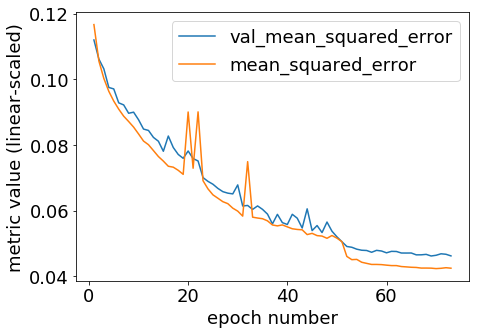

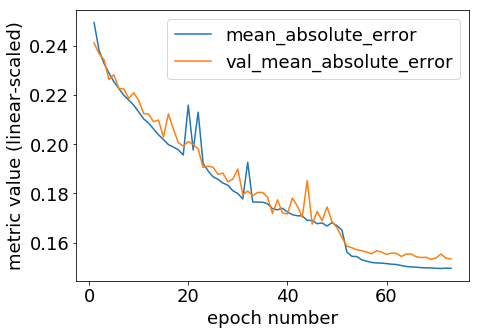

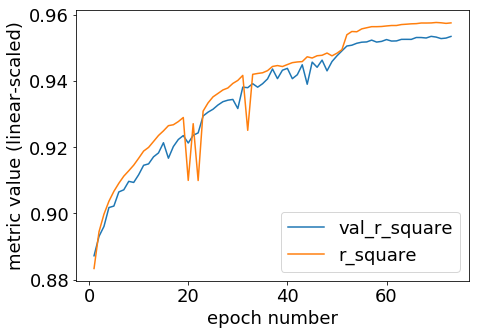

In [123]:
instance.plot_metrics(fnmatch_criteria="*mean_s*", yscale="linear")
instance.plot_metrics(fnmatch_criteria="*absolute*", yscale="linear")
instance.plot_metrics(fnmatch_criteria="*r_s*", yscale="linear")

checking results:

In [124]:

errors, recon = utils.get_recon_errors([train_norm, test_norm, data_norm, signal_norm], autoencoder)
(train_err, test_err, data_err, signal_err) = errors
(train_recon, test_recon, data_recon, signal_recon) = recon



data_table :: plotting distrubution(s) for table(s) ["'background' normed to 'train'", "'background' normed to 'train' pred"]


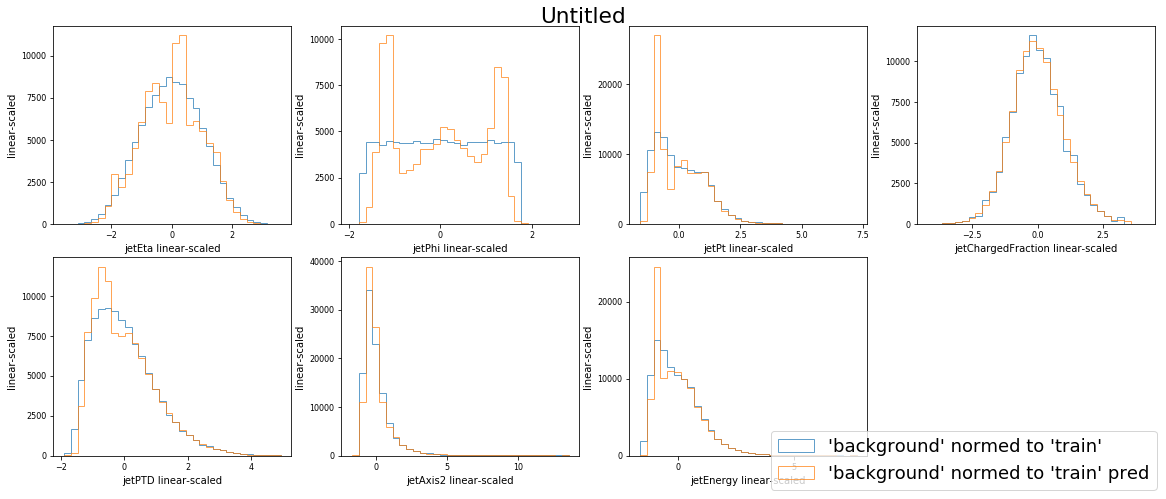

data_table :: plotting distrubution(s) for table(s) ["'signal' normed to 'train'", "'signal' normed to 'train' pred"]


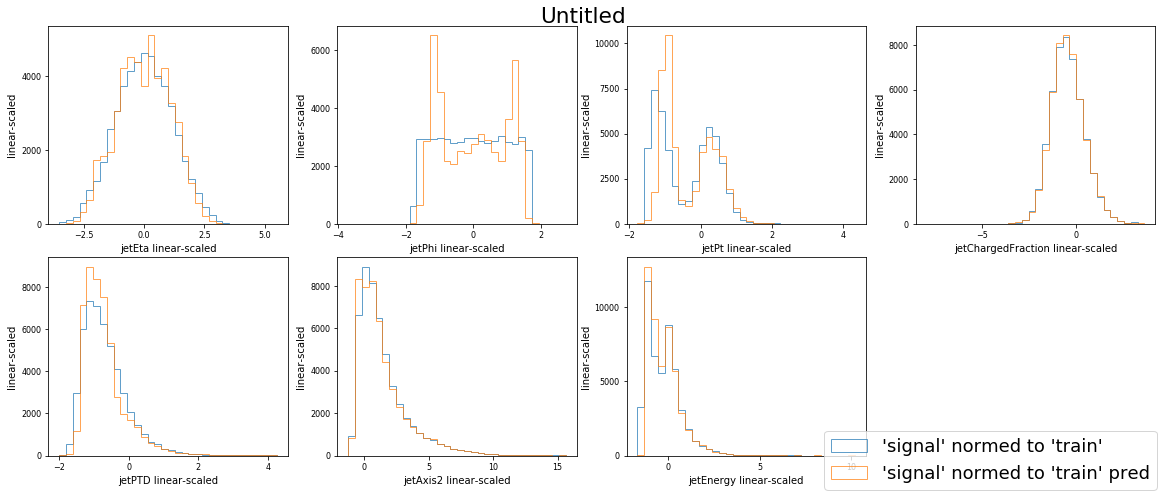

In [125]:
data_norm.plot(data_recon, normed=0)
signal_norm.plot(signal_recon, normed=0)

data_table :: plotting distrubution(s) for table(s) ["'background' normed to 'train' error", "'signal' normed to 'train' error"]


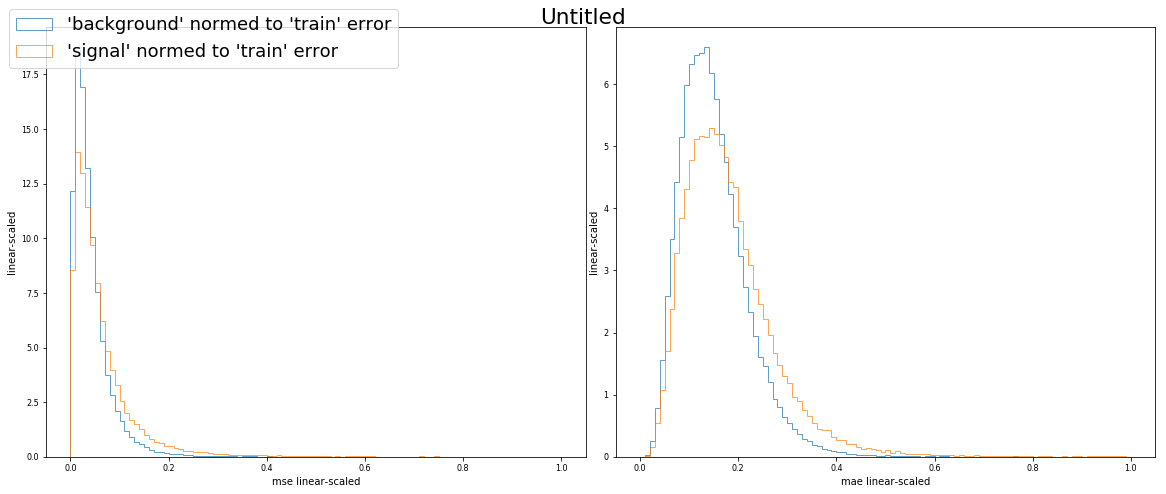

In [126]:
data_err.plot(signal_err, figloc="upper left", bins=100, rng=(0,1), normed=1)

auc value: 0.59574495048


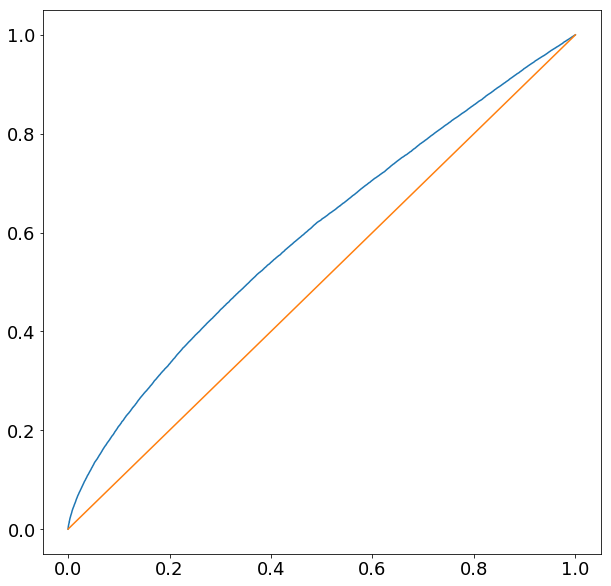

{'auc': 0.59574495048012777,
 'roc': (array([  0.00000000e+00,   0.00000000e+00,   9.66968361e-06, ...,
           9.99990330e-01,   1.00000000e+00,   1.00000000e+00]),
  array([  2.01954924e-05,   6.05864771e-05,   6.05864771e-05, ...,
           9.99979805e-01,   9.99979805e-01,   1.00000000e+00]),
  array([ 3.29648423,  1.62809567,  1.55162271, ...,  0.01164958,
          0.01022629,  0.00814099]))}

In [127]:
utils.roc_auc_plot(data_err, signal_err)

data_table :: plotting distrubution(s) for table(s) ['train_reps', 'test_reps']


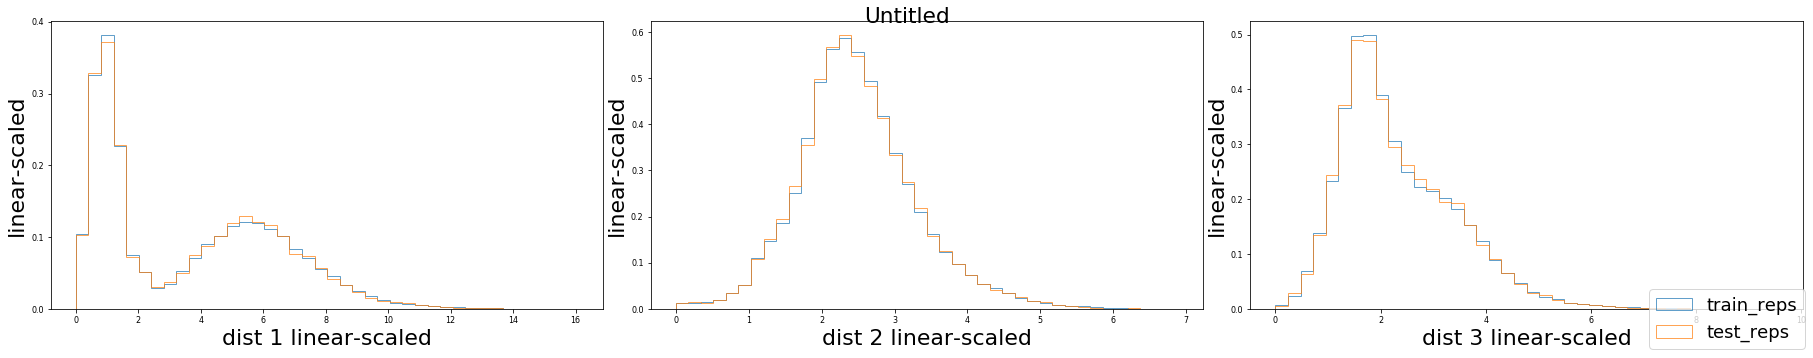

In [128]:
encoder, decoder = autoencoder.layers[1:]
train_reps, test_reps = (
    utils.data_table(encoder.predict(train_norm.data), name="train_reps"),
    utils.data_table(encoder.predict(test_norm.data), name="test_reps")
)
train_reps.plot([test_reps], cols=5, figsize=(25,5), fontsize=22, normed=1, bins=40)

In [108]:
def r_square_np(true, pred):
    SS_res = np.sum(np.square(true - pred), axis=1)
    SS_tot = np.sum(np.square(true - np.mean(true, axis=0)), axis=1)
    return 1. - SS_res/SS_tot

def get_errors(true, pred, out_name="errors", functions=["mse", "mae", r_square_np], names=[None, None, "r_square"]):
    import tensorflow as tf
    if names is None:
        names = ['err {}'.format(i) for i in range(len(functions))]
    
    functions_keep = []
    for i,f in enumerate(functions):
        if isinstance(f, str):
            fuse = getattr(keras.losses, f)
            functions_keep.append(fuse)
            names[i] = f
        else:
            functions_keep.append(f)
    
    raw = [func(true, pred) for func in functions_keep]
    raw = np.asarray(map(lambda x: K.eval(x) if isinstance(x, tf.Tensor) else x, raw)).T
    return utils.data_table(
        raw,
        headers=[str(f) for f in names],
        name=out_name
    )

errors = get_errors(norm.data, data_reconstructed_norm.data, "all errors")
tagged_norm = [train_raw.norm(t, **norm_args) for t in tagged]
# tagged_recon_norm = [utils.data_table(autoencoder.predict(t.data), name=t.name + "_norm", headers=t.headers) for t in tagged]
errors_tagged = [get_errors(t.data, autoencoder.predict(t.data), "error " + t.name.split("normed")[0].strip().strip("'")) for t in tagged_norm]

NameError: name 'norm' is not defined

(18999, 3) error down
(38841, 3) error up
(25377, 3) error strange
(9577, 3) error charm
(3341, 3) error bottom
(7281, 3) error gluon


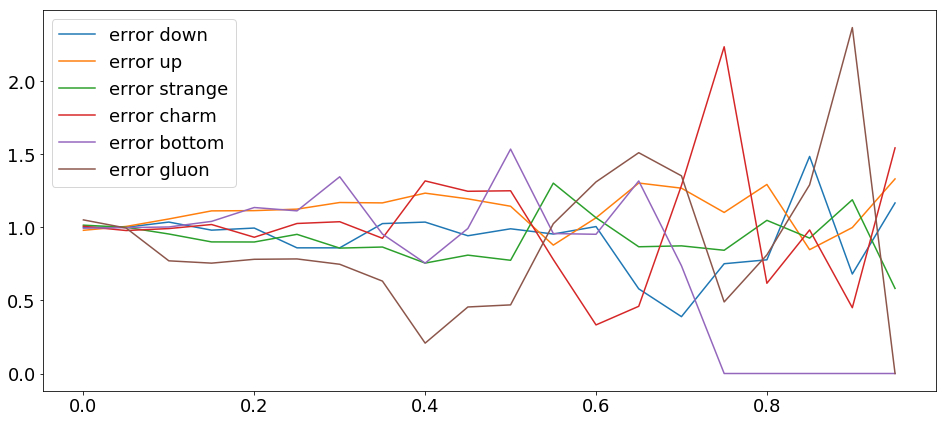

In [88]:
import matplotlib.pyplot as plt

metric = 'mse'
rng = (0,1)
bins= 20
ecounts, ebins = np.histogram(errors[metric], range=rng, bins=bins, normed=1)
for e in errors_tagged:
    counts, bins = np.histogram(e[metric], range=rng, bins=bins, normed=1)
    ratio = counts.astype(float)/ecounts
    plt.plot(bins[:-1], ratio, label=e.name)
    print e.shape, e.name
plt.legend()
plt.show()
#     errors.plot([e], values=metric, rng=rng, normed=1, yscale="log")

data_table :: plotting distrubution(s) for table(s) ['all errors', 'error down', 'error up', 'error strange', 'error charm', 'error bottom', 'error gluon']


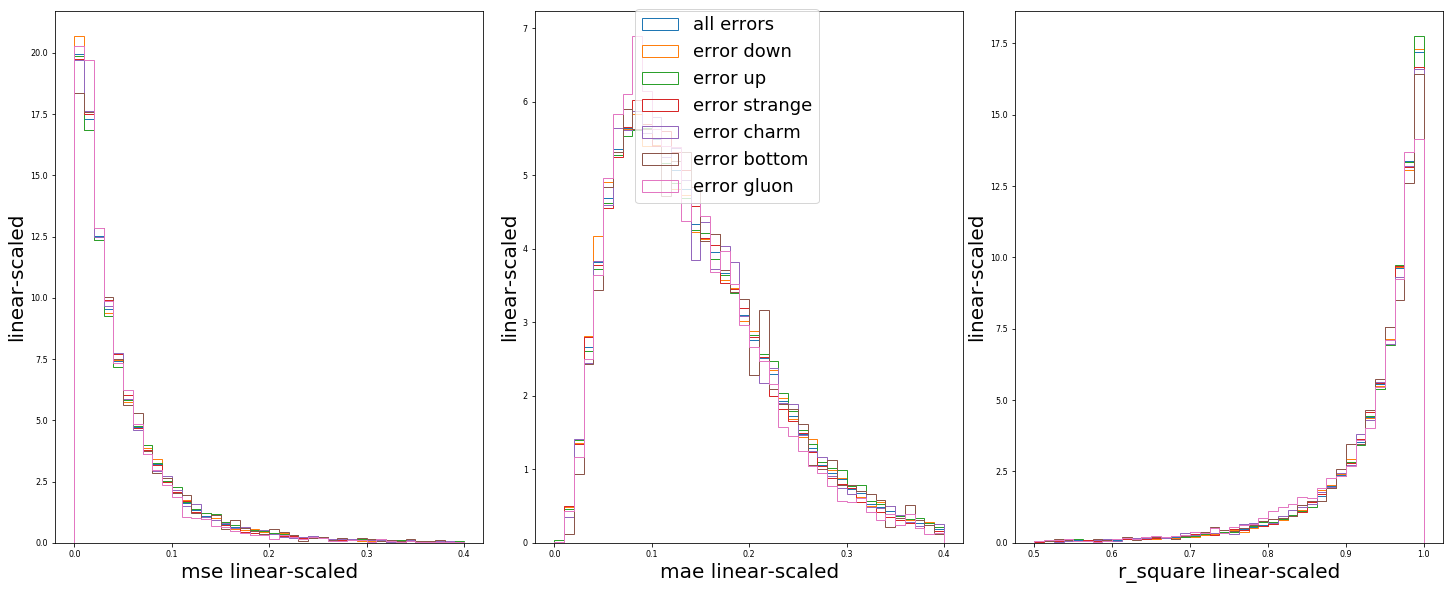

data_table :: plotting distrubution(s) for table(s) ['all errors', 'error down', 'error up', 'error strange', 'error charm', 'error bottom', 'error gluon']


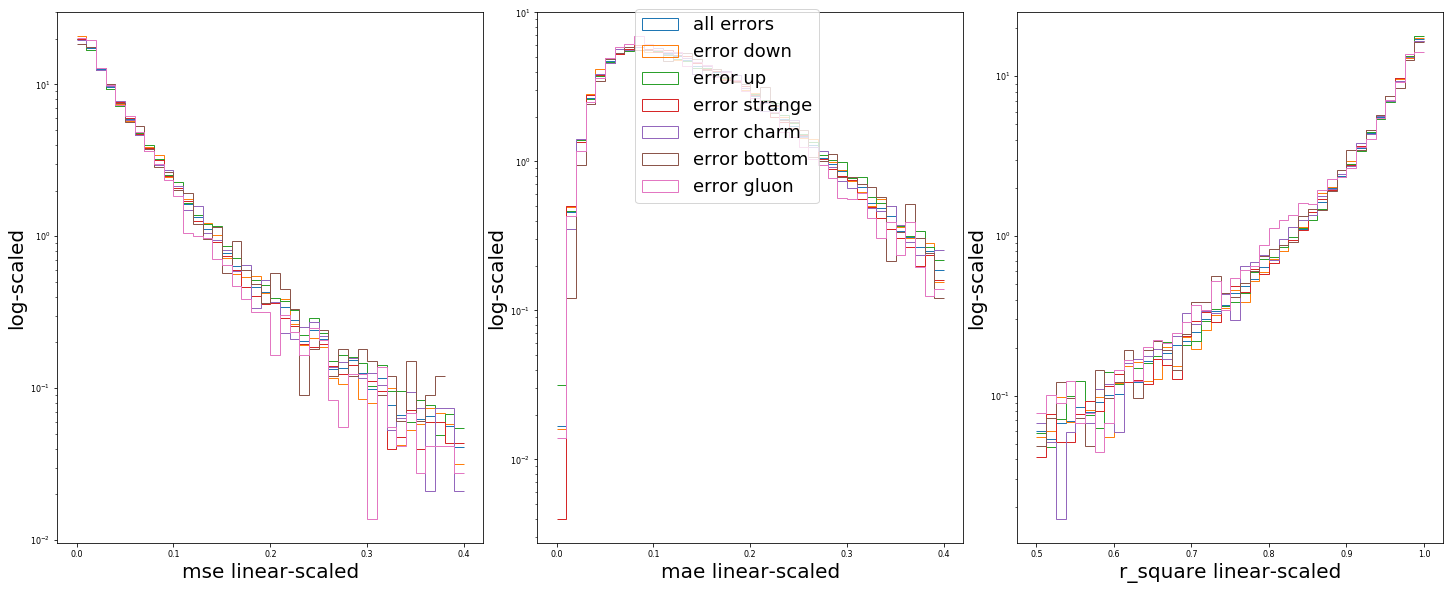

data_table :: plotting distrubution(s) for table(s) ['all errors', 'error down', 'error up', 'error strange', 'error charm', 'error bottom', 'error gluon']


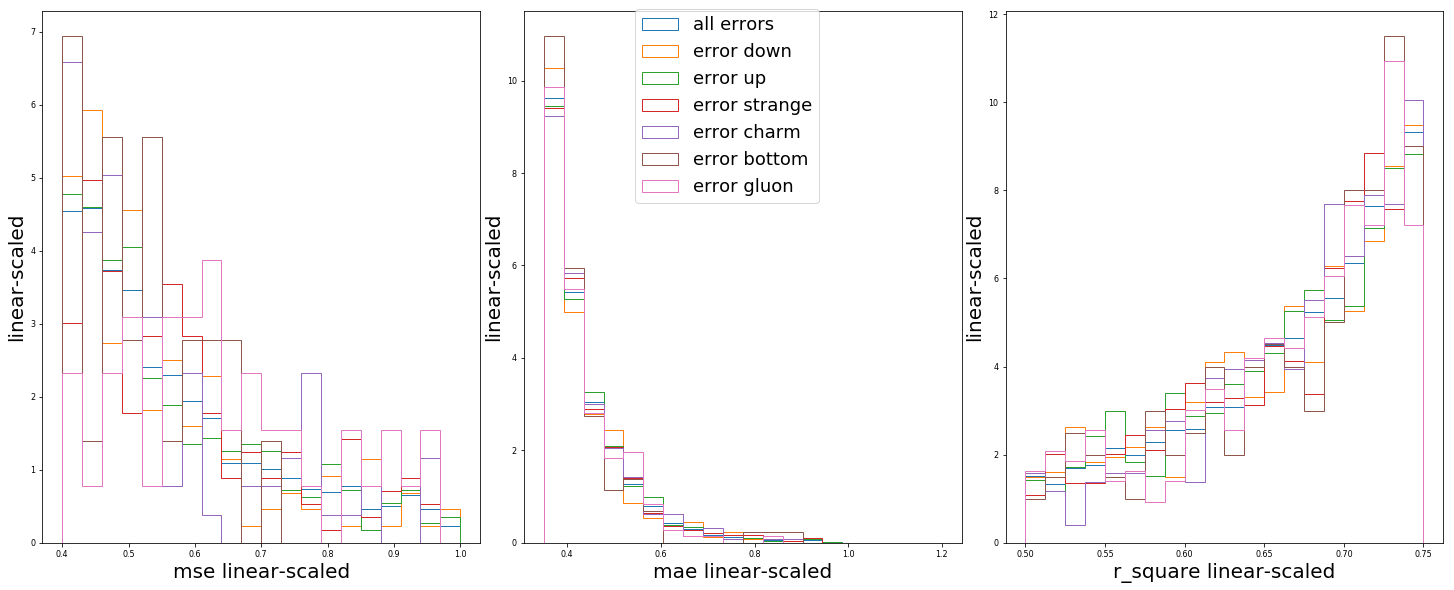

In [33]:
errors.plot(
    errors_tagged,
    figsize=(20,8), 
    bins=40,
    rng=((0,0.4), (0, 0.4), (.5,1)),
    fontsize=20, cols=3, 
    figloc="upper center",
    normed=True,
    yscale="linear",
    histtype="step",
    alpha=1
)
errors.plot(
    errors_tagged,
    figsize=(20,8), 
    bins=40,
    rng=((0,0.4), (0, 0.4), (.5,1)),
    fontsize=20, cols=3, 
    figloc="upper center",
    normed=True,
    yscale="log",
    histtype="step",
    alpha=1
)
errors.plot(
    errors_tagged,
    figsize=(20,8), 
    bins=20,
    rng=((.4,1.), (.35,1.2), (.5,.75)),
    fontsize=20, cols=3, 
    figloc="upper center",
    normed=True,
    yscale="linear",
    histtype="step",
    alpha=1
)

In [21]:
import keras
errors = utils.data_table(np.asarray(map(
        lambda x: keras.backend.eval(getattr(keras.losses, x)(data.norm(**norm_args).data, data_recon_norm.data)),
        ["mse", "mae"]
    )).T,                      
    headers=["mse", "mae"],
    name="errors"
)
outlier_fraction = 0.02
index = np.argsort(errors.mse)
out_index = index[-int(outlier_fraction*len(errors)):]
reg_index = index[:-int(outlier_fraction*len(errors))]
# print out_index.size + reg_index.size,len(errors)
# print out_index.size, reg_index.size
out,reg = (
    utils.data_table(data.data[out_index], headers=data.headers, name="outliers (top {})".format(outlier_fraction)), 
    utils.data_table(data.data[reg_index], headers=data.headers, name="normal")
)
out_reps, reg_reps = (
    utils.data_table(all_reps.data[out_index], headers=all_reps.headers, name="outlier reps"), 
    utils.data_table(all_reps.data[reg_index], headers=all_reps.headers, name="normal reps")
)
out_reps.plot(reg_reps, normed=1, bins=50, figsize=(20,4))
# reg.plot(out, normed=1, bins=50, figsize=(20,10))

NameError: global name 'data_recon_norm' is not defined